In [1]:
import os
import csv
import re
from typing import List
from itertools import product
import pickle

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from read_data import read_all_datasets
from util import flatten, flatten_twice
from url_tokenizer import url_tokenizer, UrlData, flatten_url_data, \
                          url_raw_splitter, url_html_decoder
from featurizer import UNTRUSTWORTHY_TLDS

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

sns.set(font='Tahoma')  # Tahoma is easy to read at small sizes

def save_fig(filename):
    new_filename = filename.replace(' ', '-').lower()
    plt.savefig(new_filename, bbox_inches = 'tight')

### These constants should be left untouched

In [3]:
# Should be left untouched
IS_HTTPS = 'IS_HTTPS'
NUM_MAIN_DOMAIN_WORDS = 'NUM_MAIN_DOMAIN_WORDS'
NUM_SUB_DOMAINS = 'NUM_SUB_DOMAINS'
IS_WWW = 'IS_WWW'
IS_WWW_WEIRD = 'IS_WWW_WEIRD'
NUM_PATH_WORDS = 'NUM_PATH_WORDS'
DOMAIN_END_VERDICT = 'DOMAIN_END_VERDICT'
SUB_DOMAINS_NUM_DIGITS = 'SUB_DOMAINS_NUM_DIGITS'
PATH_NUM_DIGITS = 'PATH_NUM_DIGITS'
ARGS_NUM_DIGITS = 'ARGS_NUM_DIGITS'
TOTAL_NUM_DIGITS = 'TOTAL_NUM_DIGITS'
CONTAINS_AT_SYMBOL = 'CONTAINS_AT_SYMBOL'
WORD_COUNT_IN_URL = 'WORD_COUNT_IN_URL'
DOMAIN_LEN = 'DOMAIN_LEN'
PATH_LEN = 'PATH_LEN'
ARGS_LEN = 'ARGS_LEN'
DOT_COUNT_IN_PATH_AND_ARGS = 'DOT_COUNT_IN_PATH_AND_ARGS'
CAPITAL_COUNT = 'CAPITAL_COUNT'
DOMAIN_IS_IP_ADDRESS = 'DOMAIN_IS_IP_ADDRESS'
CONTAINS_SUSPICIOUS_SYMBOL = 'CONTAINS_SUSPICIOUS_SYMBOL'

NUM_FEATS_TOTAL = 20
SEED = 42
np.random.seed(SEED)

### These values can be changed if you want

In [4]:
VAL_PROP = 0.2
DMOZ_NUM_URLS = 50_000
RERUN_EXPERIMENTS = True

### These values should be changed to corresponding feature groups

In [5]:
FEAT0 = [IS_HTTPS, IS_WWW, IS_WWW_WEIRD] 
FEAT1 = [NUM_MAIN_DOMAIN_WORDS, NUM_SUB_DOMAINS, NUM_PATH_WORDS, WORD_COUNT_IN_URL] 
FEAT2 = [SUB_DOMAINS_NUM_DIGITS, PATH_NUM_DIGITS, ARGS_NUM_DIGITS, TOTAL_NUM_DIGITS, CAPITAL_COUNT]
FEAT3 = [DOMAIN_LEN, PATH_LEN, ARGS_LEN]
FEAT4 = [DOT_COUNT_IN_PATH_AND_ARGS]
FEAT5 = [DOMAIN_END_VERDICT]
FEAT6 = [CONTAINS_AT_SYMBOL, CONTAINS_SUSPICIOUS_SYMBOL]
FEAT7 = [DOMAIN_IS_IP_ADDRESS]

FEAT_GROUPS = [FEAT0, FEAT1, FEAT2, FEAT3, FEAT4, FEAT5, FEAT6, FEAT7]

FEAT_NAMES = [
    'Protocol',
    'Word counts',
    'Ortographic',
    'URL Areas Length',
    'Dot count',
    'Suspicious TLD',
    'Suspicious symbol',
    'IP Address'
]

### From here on out, I think you can leave mostly everything untouched and then just run it

In [6]:
FEAT_GROUPS = [sorted(feat_group) for feat_group in FEAT_GROUPS]

In [7]:
dmoz, phishing, ilp = read_all_datasets(use_sample=False)
datasets = {
    'DMOZ': dmoz.sample(DMOZ_NUM_URLS, random_state=SEED),
    'ILP': ilp.sample(frac=1, random_state=SEED),
    'Phishing': phishing.sample(frac=1, random_state=SEED)
}

In [8]:
# A modification of our original function that supports arguments determining
# what features to return or exclude
def hand_pick_features(url: str, feat_group: List[str],
                       only_include: bool) -> np.ndarray:
    try:
        url_data = url_tokenizer(url)
        words = flatten_url_data(url_data)

        url_decoded = url_html_decoder(url)
        protocol, domains_raw, path_raw, args_raw = \
            url_raw_splitter(url_decoded)

        domain_len = len(domains_raw)
        path_len = len(path_raw)
        args_len = len(args_raw)

        dot_count_in_path_and_args = path_raw.count('.') + args_raw.count('.')
        capital_count = len([char for char in url_decoded if char.isupper()])

        domain_is_ip_address = int(bool(re.match(r'(\d+\.){3}\d+',
                                                 domains_raw)))
        contain_suspicious_symbol = int(args_raw.find('\\') >= 0 or
                                        args_raw.find(':') >= 0)

        protocol, domains, path, args = url_data
        sub_domains, main_domain, domain_ending = domains

        contains_at_symbol = int(len(path) > 0 and path[-1] == '@')
        is_https = int(protocol == 'https')
        num_main_domain_words = len(main_domain)
        num_sub_domains = len(sub_domains)
        is_www = int(num_sub_domains > 0 and sub_domains[0] == 'www')
        is_www_weird = int(num_sub_domains > 0 and
                           bool(re.match(r'www.+', sub_domains[0])))
        num_path_words = len(path) - contains_at_symbol
        domain_end_verdict = int(domain_ending in UNTRUSTWORTHY_TLDS)

        sub_domain_chars = flatten(sub_domains)
        sub_domains_num_digits = len([char for char in sub_domain_chars
                                      if char.isdigit()])

        path_chars = flatten(path)
        path_num_digits = len([char for char in path_chars if char.isdigit()])

        args_flat = flatten_twice(args)
        args_chars = flatten(args_flat)
        args_num_digits = len([char for char in args_chars if char.isdigit()])

        total_num_digits = (sub_domains_num_digits
                            + path_num_digits
                            + args_num_digits)

        word_court_in_url = len(words) - contains_at_symbol

        all_features = {
            IS_HTTPS: is_https,
            NUM_MAIN_DOMAIN_WORDS: num_main_domain_words,
            NUM_SUB_DOMAINS: num_sub_domains,
            IS_WWW: is_www,
            IS_WWW_WEIRD: is_www_weird,
            NUM_PATH_WORDS: num_path_words,
            DOMAIN_END_VERDICT: domain_end_verdict,
            SUB_DOMAINS_NUM_DIGITS: sub_domains_num_digits,
            PATH_NUM_DIGITS: path_num_digits,
            ARGS_NUM_DIGITS: args_num_digits,
            TOTAL_NUM_DIGITS: total_num_digits,
            CONTAINS_AT_SYMBOL: contains_at_symbol,
            WORD_COUNT_IN_URL: word_court_in_url,
            DOMAIN_LEN: domain_len,
            PATH_LEN: path_len,
            ARGS_LEN: args_len,
            DOT_COUNT_IN_PATH_AND_ARGS: dot_count_in_path_and_args,
            CAPITAL_COUNT: capital_count,
            DOMAIN_IS_IP_ADDRESS: domain_is_ip_address,
            CONTAINS_SUSPICIOUS_SYMBOL: contain_suspicious_symbol
        }

        if only_include:
            selected_features = [all_features[name] for name in feat_group]
        else:
            selected_features = [v for k, v
                                 in sorted(all_features.items())
                                 if k not in feat_group]
        return np.array(selected_features)
    except:
        return (np.zeros(len(feat_group))
                if use_only
                else np.zeros(NUM_FEATS_TOTAL - len(feat_group)))

In [9]:
def clean_url(url: str):
    try:
        words = flatten_url_data(url_tokenizer(url))
        return ' '.join(words)
    except:
        return ''

In [10]:
def run_test(dataset, feat_group, feat_group_num, only_include, use_tfidf=False):
    tqdm.write(f'feat_group: {feat_group_num}, use_tfidf: {use_tfidf}, only_include: {only_include}')
    
    feats = np.array([hand_pick_features(url, feat_group, only_include)
                     for url in dataset['url']])
    
    num_feats = feats.shape[1]
    for i in range(num_feats):
        dataset[f'feat_{i}'] = feats[:, i]
    extra_features = [f'feat_{i}' for i in range(num_feats)]
    
    trans = StandardScaler()
    if use_tfidf:
        vectorizer_0 = TfidfVectorizer(
            analyzer='word',
            strip_accents='unicode'
        )
        trans = ColumnTransformer([
            ('tfidf_word', vectorizer_0, 'urlCleaned'),
            ('feat', StandardScaler(), extra_features)
        ])
        
        X = dataset[['urlCleaned', *extra_features]]
    else:
        X = dataset[extra_features]
        
    y = dataset['label']
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=VAL_PROP, random_state=SEED)
        

    trans.fit(X_train)
    X_train_pre = trans.transform(X_train)
    
    model = RandomForestClassifier(random_state=SEED, n_jobs=-1)
    model.fit(X_train_pre, y_train)
    
    X_val_pre = trans.transform(X_val)
    y_val_pred = model.predict(X_val_pre)
    
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    f1_micro = f1_score(y_val, y_val_pred, average='micro')
    f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
    acc = accuracy_score(y_val, y_val_pred)

    return f1_macro, f1_micro, f1_weighted, acc

In [11]:
if RERUN_EXPERIMENTS:
    rows = []

    for dataset_name, dataset in datasets.items():
        print(f'Running experiments for {dataset_name}...')
        dataset['urlCleaned'] = dataset['url'].apply(clean_url)

        params_iter = product(enumerate(FEAT_GROUPS), [True, False], [True, False])
        for (i, feat_group), use_tfidf, only_include in tqdm(list(params_iter)):
            f1_macro, f1_micro, f1_weighted, acc = \
                run_test(dataset.copy(), feat_group, i, only_include, use_tfidf)
            rows.append({
                'Dataset': dataset_name, 'Use TfIdf': use_tfidf,
                'Feature Group': i, 'Only Include': only_include,
                'F1 Macro': f1_macro, 'F1 Micro': f1_micro, 'F1 Weighted': f1_weighted,
                'Acc': acc
            })

    df = pd.DataFrame(rows)
    with open('feat-experiments.pickle', 'wb') as f:
        pickle.dump(df, f)
else:
    with open('feat-experiments.pickle', 'rb') as f:
        df = pickle.load(f)

# Score for all

In [12]:
metrics_all_features = {}
for dataset_name, dataset in tqdm(datasets.items()):
    f1_macro, f1_micro, f1_weighted, acc = run_test(dataset, [], 'All', False)
    metrics_all_features[dataset_name] = {
        'F1 Macro': f1_macro, 'F1 Micro': f1_micro,
        'F1 Weighted': f1_weighted, 'Acc': acc
    }

feat_group: All, use_tfidf: False, only_include: False
feat_group: All, use_tfidf: False, only_include: False
feat_group: All, use_tfidf: False, only_include: False



In [13]:
metrics_all_features

{'DMOZ': {'F1 Macro': 0.1848354490677833,
  'F1 Micro': 0.2715,
  'F1 Weighted': 0.23659991773261882,
  'Acc': 0.2715},
 'ILP': {'F1 Macro': 0.5662548814485627,
  'F1 Micro': 0.7339003645200487,
  'F1 Weighted': 0.7228315241839091,
  'Acc': 0.7339003645200486},
 'Phishing': {'F1 Macro': 0.9941722305403651,
  'F1 Micro': 0.9960304333443599,
  'F1 Weighted': 0.996020999000891,
  'Acc': 0.9960304333443599}}

# Plots

### Basic exploration

In [14]:
def get_hori_lines(metric='F1 Macro'):
    return [metrics[metric] for metrics in metrics_all_features.values()]


def split_dataset(df):
    dropper = lambda df: df.drop(['Use TfIdf', 'Only Include'], axis=1)
    
    with_tfidf = df[df['Use TfIdf'] == True]
    with_tfidf_include = with_tfidf[with_tfidf['Only Include'] == True]
    with_tfidf_exclude = with_tfidf[with_tfidf['Only Include'] == False]
    
    without_tfidf = df[df['Use TfIdf'] == False]
    without_tfidf_include = without_tfidf[without_tfidf['Only Include'] == True]
    without_tfidf_exclude = without_tfidf[without_tfidf['Only Include'] == False]
    
    return (
        with_tfidf_include.drop(['Use TfIdf', 'Only Include'], axis=1),
        with_tfidf_exclude.drop(['Use TfIdf', 'Only Include'], axis=1),
        without_tfidf_include.drop(['Use TfIdf', 'Only Include'], axis=1),
        without_tfidf_exclude.drop(['Use TfIdf', 'Only Include'], axis=1)
    )

with_tfidf_include, with_tfidf_exclude, without_tfidf_include, without_tfidf_exclude = \
    split_dataset(df)

In [19]:
def plot_scores(df, desc, y='F1 Macro', include_hori=True):
    ax = sns.catplot(data=df, x='Feature Group', y=y,
                     col='Dataset', kind='bar')
    
    if include_hori:
        hori_lines = get_hori_lines(y)
        for sub_ax, hori_line in zip(ax.axes[0], hori_lines):
            sub_ax.axhline(hori_line, ls='--')
    
    ax.fig.subplots_adjust(top=0.85)
    ax.fig.suptitle(desc)
    plt.show()

(0.0, 1.05)

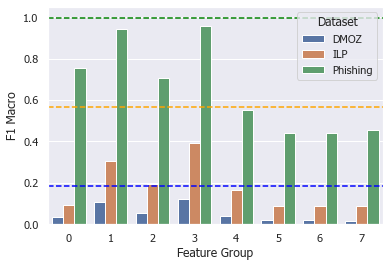

In [20]:
ax = sns.barplot(data=without_tfidf_include,
            x='Feature Group', y='F1 Macro',
            hue='Dataset', dodge=True)

for color, hori_line in zip(['blue', 'orange', 'green'], get_hori_lines()):
    ax.axhline(hori_line, ls='--', color=color)
    
plt.ylim([0, 1.05])

<AxesSubplot:xlabel='Feature Group', ylabel='F1 Macro'>

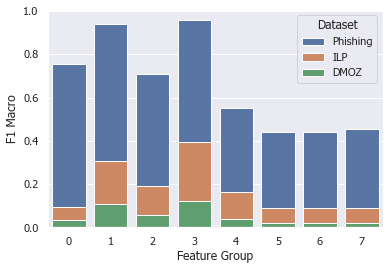

In [21]:
sns.barplot(data=without_tfidf_include[::-1],
            x='Feature Group', y='F1 Macro',
            hue='Dataset', dodge=False)

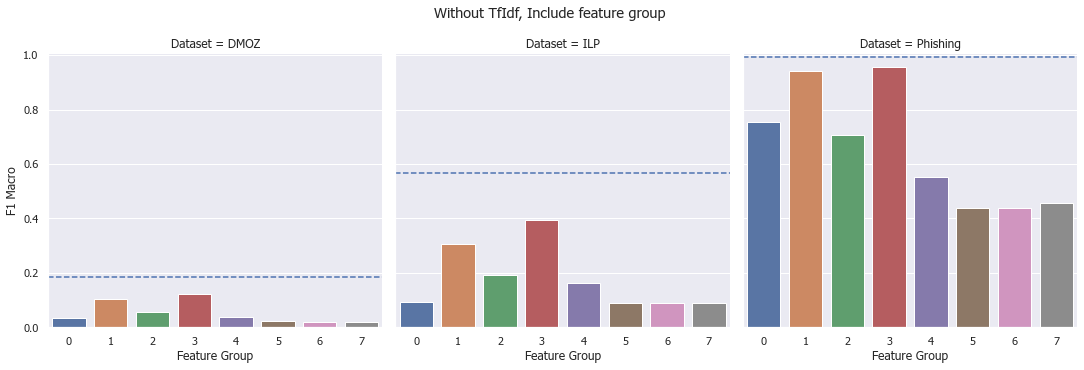

In [22]:
plot_scores(without_tfidf_include, 'Without TfIdf, Include feature group')

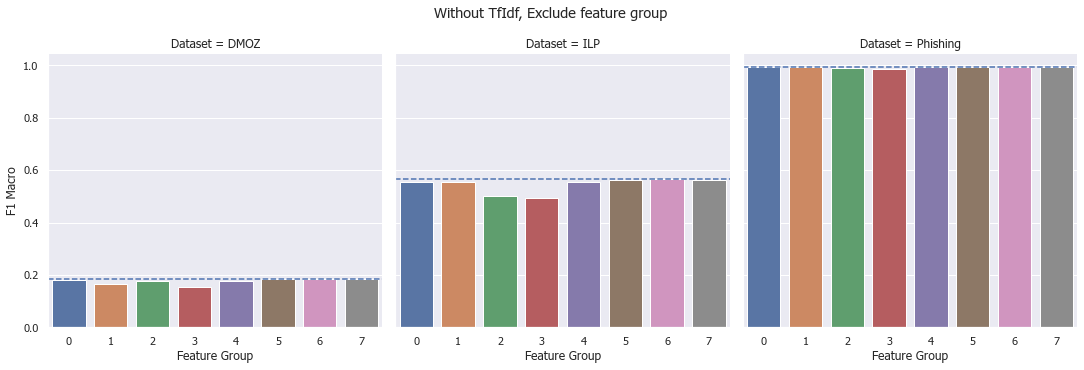

In [23]:
plot_scores(without_tfidf_exclude, 'Without TfIdf, Exclude feature group')

### Plot included in report

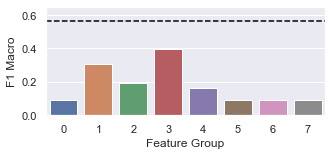

In [24]:
sns.set(rc={'figure.figsize':(5, 2)})


df_ilp = without_tfidf_include[without_tfidf_include['Dataset'] == 'ILP']
ax = sns.barplot(data=df_ilp,
            x='Feature Group', y='F1 Macro')

ax.axhline(get_hori_lines()[1], ls='--', color='black')
plt.ylim([0, 0.65])
save_fig('feature-contrib.pdf')